31/31 [==============================] - 0s 2ms/step


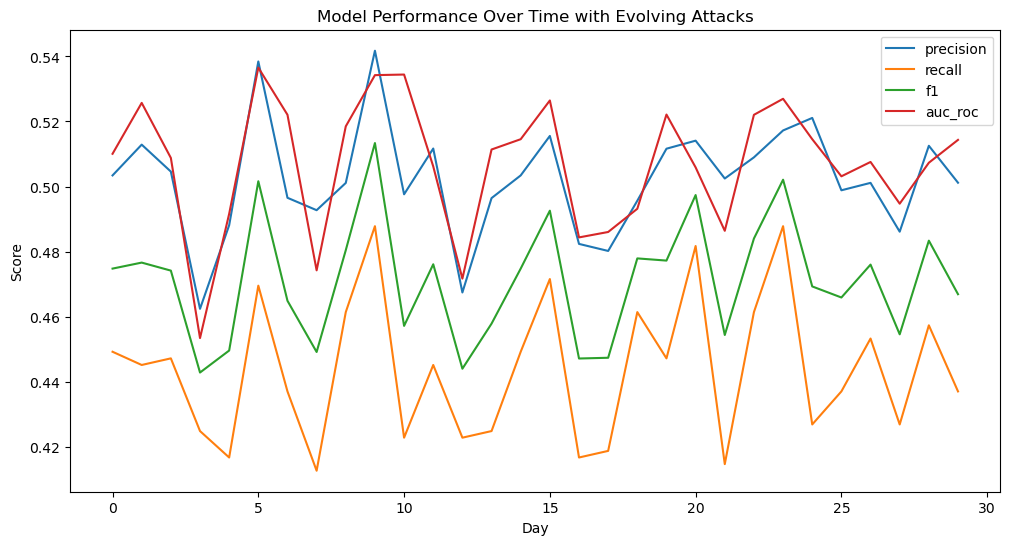

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your trained model
model = load_model('lstm_binary_classification_model.keras')

# Define attack types
attack_types = ['TFTP', 'DrDoS_DNS', 'DrDoS_MSSQL', 'DrDoS_NetBIOS', 'DrDoS_NTP', 
                'DrDoS_SNMP', 'DrDoS_SSDP', 'DrDoS_UDP', 'Syn', 'UDP-lag', 'WebDDoS', 'Portmap']

def generate_synthetic_data(n_samples, seq_length=10, n_features=29, attack_type='BENIGN'):
    data = np.random.randn(n_samples, seq_length, n_features)
    
    # Adjust data based on attack type
    if attack_type != 'BENIGN':
        if 'DrDoS' in attack_type:
            # Increase values in certain features to simulate reflection
            data[:, :, [0, 2, 4]] *= 2  # Assuming these indices represent relevant features
        elif attack_type == 'Syn':
            # Increase SYN flag counts
            data[:, :, 5] = np.abs(data[:, :, 5]) + 1  # Assuming index 5 represents SYN flags
        elif attack_type in ['UDP-lag', 'TFTP']:
            # Increase UDP-related features
            data[:, :, [1, 3]] *= 1.5  # Assuming these indices represent UDP-related features
        elif attack_type == 'WebDDoS':
            # Modify features related to HTTP traffic
            data[:, :, 6] = np.abs(data[:, :, 6]) + 0.5  # Assuming index 6 represents HTTP-related feature
    
    label = 0 if attack_type == 'BENIGN' else 1
    return data, np.full(n_samples, label)

# Function to evaluate model
def evaluate_model(X, y):
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int).ravel()
    return {
        'precision': precision_score(y, y_pred_binary),
        'recall': recall_score(y, y_pred_binary),
        'f1': f1_score(y, y_pred_binary),
        'auc_roc': roc_auc_score(y, y_pred.ravel())
    }

# Simulation of evolving attacks
def simulate_evolving_attacks(n_days=30, samples_per_day=1000, seq_length=10, n_features=29):
    results = []
    for day in range(n_days):
        X_list, y_list = [], []
        
        # Generate benign traffic
        X_benign, y_benign = generate_synthetic_data(samples_per_day // 2, seq_length, n_features, 'BENIGN')
        X_list.append(X_benign)
        y_list.append(y_benign)
        
        # Generate evolving attack traffic
        attack_samples = samples_per_day // 2
        for attack_type in attack_types:
            n_samples = attack_samples // len(attack_types)
            X_attack, y_attack = generate_synthetic_data(n_samples, seq_length, n_features, attack_type)
            
            # Add evolving component
            evolution_factor = day / n_days
            X_attack += evolution_factor * np.random.randn(*X_attack.shape) * 0.1
            
            X_list.append(X_attack)
            y_list.append(y_attack)
        
        X = np.vstack(X_list)
        y = np.hstack(y_list)
        
        # Evaluate model
        metrics = evaluate_model(X, y)
        metrics['day'] = day
        results.append(metrics)
    
    return pd.DataFrame(results)

# Run simulation and plot results
simulation_results = simulate_evolving_attacks()

plt.figure(figsize=(12, 6))
for metric in ['precision', 'recall', 'f1', 'auc_roc']:
    plt.plot(simulation_results['day'], simulation_results[metric], label=metric)
plt.xlabel('Day')
plt.ylabel('Score')
plt.title('Model Performance Over Time with Evolving Attacks')
plt.legend()
plt.show()

In [14]:
import random
import pandas as pd
from scapy.all import *
from scapy.utils import rdpcap
from scapy.layers.inet import IP, TCP, UDP
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import time



def generate_normal_traffic(target_ip, target_port, duration=60):
    start_time = time.time()
    while time.time() - start_time < duration:
        # Simulate HTTP traffic
        packet = IP(dst=target_ip) / TCP(dport=target_port, sport=random.randint(1024, 65535)) / "GET / HTTP/1.1\r\nHost: {}\r\n\r\n".format(target_ip)
        send(packet, verbose=False)
        
        # Simulate FTP traffic
        packet = IP(dst=target_ip) / TCP(dport=21, sport=random.randint(1024, 65535)) / "USER anonymous\r\n"
        send(packet, verbose=False)
        
        time.sleep(random.uniform(0.1, 0.5))  # Mimic random user activity

# Example usage
generate_normal_traffic(target_ip='192.168.1.2', target_port=80)

def generate_ddos_traffic(target_ip, target_port, duration=60):
    start_time = time.time()
    while time.time() - start_time < duration:
        packet = IP(dst=target_ip) / TCP(dport=target_port, sport=random.randint(1024, 65535), flags="S")
        send(packet, verbose=False)
        
        time.sleep(random.uniform(0.001, 0.01))  # High volume, low interval

# Example usage
generate_ddos_traffic(target_ip='192.168.1.2', target_port=80)



In [12]:
# Load packets from the saved pcap
packets = rdpcap('network_traffic.pcap')

# Example function to extract the necessary features from packets
def extract_features(packets):
    features = []
    for packet in packets:
        if IP in packet and TCP in packet:
            # Extracting features from each packet (simplified version)
            feature = {
                'Protocol': packet[IP].proto,
                'Flow Duration': random.randint(1, 10000),  # Placeholder, typically computed over a flow
                'Total Fwd Packets': 1,  # Simplified for example (would be higher in real flows)
                'Total Backward Packets': 0,  # Simplified for example
                'Flow Packets/s': random.random(),  # Placeholder, typically computed over a flow
                'Total Length of Fwd Packets': len(packet[TCP].payload),
                'Fwd Packet Length Max': len(packet[TCP].payload),  # Simplified
                'Bwd Packet Length Min': 0,  # Placeholder
                'Bwd Packet Length Mean': 0,  # Placeholder
                'Flow IAT Min': random.random(),  # Placeholder
                'Bwd IAT Total': random.random(),  # Placeholder
                'Bwd IAT Mean': random.random(),  # Placeholder
                'Bwd IAT Min': random.random(),  # Placeholder
                'Fwd PSH Flags': int(packet[TCP].flags.PSH),
                'Fwd Header Length': len(packet[TCP]),  # Size of the TCP header
                'Bwd Packets/s': 0,  # Placeholder
                'SYN Flag Count': int(packet[TCP].flags.S),
                'URG Flag Count': int(packet[TCP].flags.U),
                'CWE Flag Count': 0,  # Placeholder
                'Down/Up Ratio': random.random(),  # Placeholder
                'Init_Win_bytes_backward': 0,  # Placeholder
                'min_seg_size_forward': random.randint(20, 40),  # Placeholder
                'Active Mean': random.random(),  # Placeholder
                'Active Std': random.random(),  # Placeholder
                'Idle Std': random.random(),  # Placeholder
                'Inbound': random.choice([0, 1]),  # Placeholder
            }
            features.append(feature)
    return pd.DataFrame(features)

# Extract features from the packets
features_df = extract_features(packets)


In [13]:
# Check and pad the feature set to ensure it has 29 features as expected by the model
if features_df.shape[1] < 29:
    for i in range(29 - features_df.shape[1]):
        features_df[f'Placeholder_{i}'] = random.random()

# Load your trained LSTM model
model = load_model('lstm_binary_classification_model.keras')

# Assuming you have a fitted StandardScaler used during training
scaler = StandardScaler()
# Scale the features
features_scaled = scaler.fit_transform(features_df)

# Reshape features for LSTM model input (samples, time_steps, features)
# Assuming a sequence length of 10 time steps
sequence_length = 10
num_features = features_scaled.shape[1]

# Reshape into (num_samples, sequence_length, num_features)
num_samples = features_scaled.shape[0] // sequence_length
features_scaled = features_scaled[:num_samples * sequence_length]
features_scaled = features_scaled.reshape((num_samples, sequence_length, num_features))

# Predict with the model
predictions = model.predict(features_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Create true labels (0 for normal, 1 for DDoS)
# For simplicity, assume first half is normal and second half is DDoS
true_labels = np.array([0] * (num_samples // 2) + [1] * (num_samples // 2))

# Evaluate model performance
print(classification_report(true_labels, predicted_classes))

4/4 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.46      0.56      0.50        50
           1       0.44      0.34      0.38        50

    accuracy                           0.45       100
   macro avg       0.45      0.45      0.44       100
weighted avg       0.45      0.45      0.44       100



In [1]:
import numpy as np
from tensorflow.keras.models import load_model
import time

# Load the best performing model (assuming it's the CNN based on previous discussions)
model = load_model('cnn_ddos_detection_model.keras')

def generate_traffic_sample(is_attack=False):
    """
    Generate a simulated traffic sample.
    This is a simplified version and should be adapted based on your actual features.
    """
    sample = np.random.rand(29)  # Assuming 29 features based on previous info
    if is_attack:
        # Simulate attack patterns (this is highly simplified)
        sample[0] = np.random.rand() * 0.9 + 0.1  # Higher values for certain features
        sample[1] = np.random.rand() * 0.8 + 0.2
    return sample.reshape(1, 29, 1)  # Reshape for model input

def simulate_traffic(duration_seconds=60, attack_probability=0.1):
    start_time = time.time()
    attack_detected = False
    samples_processed = 0
    false_positives = 0
    true_positives = 0

    print("Starting DDoS detection simulation...")
    while time.time() - start_time < duration_seconds:
        is_attack = np.random.rand() < attack_probability
        sample = generate_traffic_sample(is_attack)
        
        # Model prediction
        prediction = model.predict(sample, verbose=0)
        is_detected_attack = prediction[0][0] > 0.5

        samples_processed += 1

        if is_detected_attack:
            if is_attack:
                print("Attack detected correctly!")
                true_positives += 1
                attack_detected = True
            else:
                print("False alarm: Normal traffic classified as attack.")
                false_positives += 1
        elif is_attack:
            print("Warning: Attack missed.")
        
        time.sleep(0.1)  # Simulate processing time

    print(f"\nSimulation complete. Duration: {duration_seconds} seconds")
    print(f"Samples processed: {samples_processed}")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Positive Rate: {false_positives / samples_processed:.2%}")
    if attack_detected:
        print("DDoS attack was successfully detected during the simulation.")
    else:
        print("No DDoS attack was detected during the simulation.")

# Run the simulation
simulate_traffic(duration_seconds=60, attack_probability=0.1)




Starting DDoS detection simulation...
Attack detected correctly!

Simulation complete. Duration: 60 seconds
Samples processed: 279
True Positives: 1
False Positives: 0
False Positive Rate: 0.00%
DDoS attack was successfully detected during the simulation.
